/tmp/ipykernel_15877/1145285039.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby('_AGEG5YR_lab')['_SMOKGRP_lab']
/tmp/ipykernel_15877/1145285039.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ratio.index, fontfamily='serif', fontsize=11)


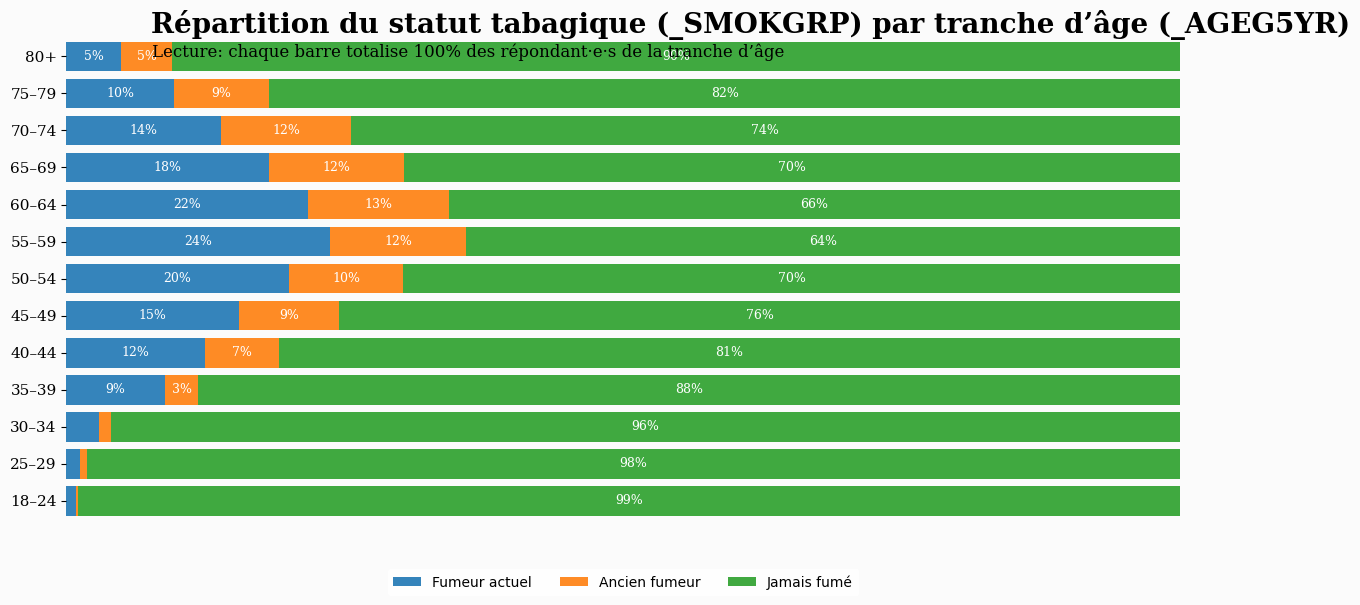

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1) Recodage des variables
# ---------------------------
# Tranches d’âge BRFSS (_AGEG5YR)
age_map = {
    1: '18–24', 2: '25–29', 3: '30–34', 4: '35–39', 5: '40–44',
    6: '45–49', 7: '50–54', 8: '55–59', 9: '60–64', 10: '65–69',
    11: '70–74', 12: '75–79', 13: '80+'
}
age_order = ['18–24','25–29','30–34','35–39','40–44','45–49',
             '50–54','55–59','60–64','65–69','70–74','75–79','80+']

# Groupes de tabagisme (_SMOKGRP) — selon la doc BRFSS, souvent:
# 1 = Fumeur actuel, 2 = Ancien fumeur, 3 = N’a jamais fumé
# (Les codes 7/9 = "Don’t know/Refused" -> NaN)
smk_map = {1: 'Fumeur actuel', 2: 'Ancien fumeur', 3: 'Jamais fumé'}

smk_order = ['Fumeur actuel', 'Ancien fumeur', 'Jamais fumé']  # ordre d’empilement

df_plot = pd.read_csv("data/train.csv")

df_plot['_AGEG5YR_lab'] = df_plot['_AGEG5YR'].map(age_map)
df_plot['_SMOKGRP_lab']  = df_plot['_SMOKGRP'].map(smk_map)

# On enlève les valeurs manquantes / hors codes prévus
df_plot = df_plot[df_plot['_AGEG5YR_lab'].notna() & df_plot['_SMOKGRP_lab'].notna()]

# Assure l’ordre catégoriel pour l’affichage
df_plot['_AGEG5YR_lab'] = pd.Categorical(df_plot['_AGEG5YR_lab'], categories=age_order, ordered=True)
df_plot['_SMOKGRP_lab']  = pd.Categorical(df_plot['_SMOKGRP_lab'],  categories=smk_order,  ordered=True)

# ---------------------------------
# 2) Table de fréquences + ratios
# ---------------------------------
# Comptages par âge x groupe de tabagisme
tab = (
    df_plot.groupby('_AGEG5YR_lab')['_SMOKGRP_lab']
           .value_counts()
           .unstack(fill_value=0)
           .reindex(age_order)
           .reindex(columns=smk_order, fill_value=0)
)

tab_sum = tab.sum(axis=1)
ratio = (tab.T / tab_sum).T  # proportions par ligne (âge)

# ---------------------------------
# 3) Graphique en barres empilées
# ---------------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# Segments empilés (on cumule les "left")
left = np.zeros(len(ratio))
for col in smk_order:
    ax.barh(ratio.index, ratio[col].values, left=left, label=col, alpha=0.9)
    left += ratio[col].values

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(ratio.index, fontfamily='serif', fontsize=11)

# Étiquettes de pourcentage (on n’affiche que si segment >= 3 % pour éviter l’encombrement)
for yi, age in enumerate(ratio.index):
    cum = 0.0
    for col in smk_order:
        width = ratio.loc[age, col]
        if width >= 0.03:
            ax.annotate(f"{int(round(width*100))}%",
                        xy=(cum + width/2, yi),
                        va='center', ha='center',
                        fontsize=9, fontweight='light', fontfamily='serif',
                        color='white')
        cum += width

# Titres & style
fig.text(0.13, 0.95, 'Répartition du statut tabagique (_SMOKGRP) par tranche d’âge (_AGEG5YR)', 
         fontsize=20, fontweight='bold', fontfamily='serif')
fig.text(0.131, 0.91, 'Lecture: chaque barre totalise 100% des répondant·e·s de la tranche d’âge', 
         fontsize=12, fontfamily='serif')

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.legend(loc='lower center', ncol=3, facecolor='white', edgecolor='white', bbox_to_anchor=(0.5, -0.12))
plt.tight_layout()
plt.show()



/tmp/ipykernel_15877/843151019.py:75: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_plot.pivot_table(index='_AGEG5YR_lab', columns='MAXDRNKS_cat',
/tmp/ipykernel_15877/843151019.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ratio.index, fontfamily='serif', fontsize=11)


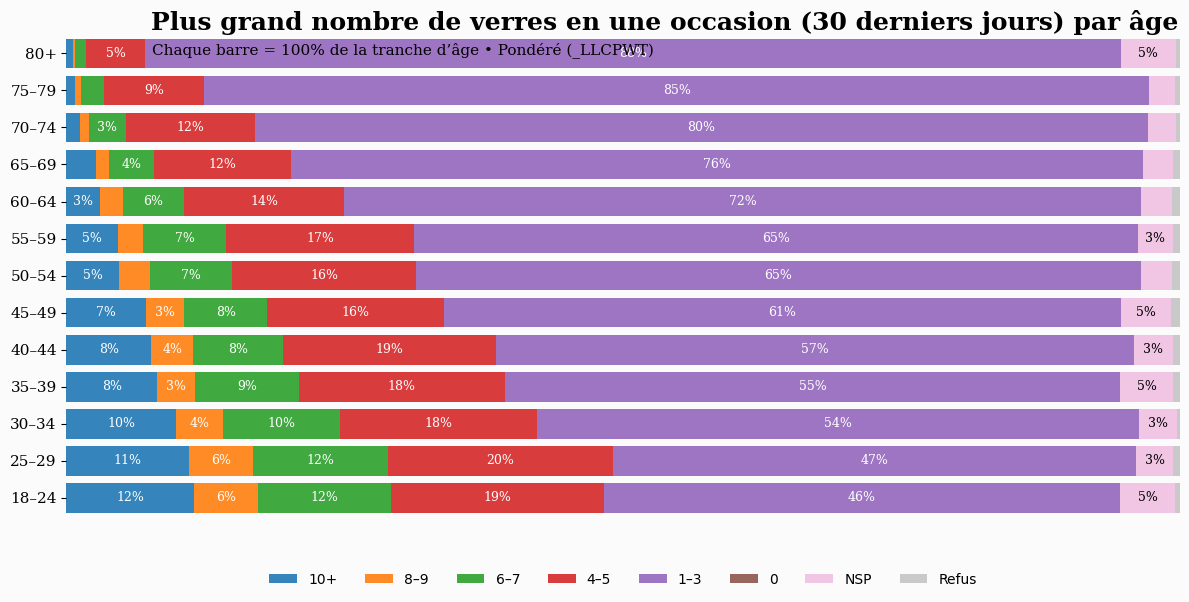

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1) Paramètres & recodages
# ---------------------------
# Tranches d’âge BRFSS (_AGEG5YR)
age_map = {
    1: '18–24', 2: '25–29', 3: '30–34', 4: '35–39', 5: '40–44',
    6: '45–49', 7: '50–54', 8: '55–59', 9: '60–64', 10: '65–69',
    11: '70–74', 12: '75–79', 13: '80+'
}
age_order = ['18–24','25–29','30–34','35–39','40–44','45–49',
             '50–54','55–59','60–64','65–69','70–74','75–79','80+']

# Catégorisation de MAXDRNKS (0–76)
# Adapte librement les bornes si besoin
def bin_maxdrnks(x):
    if pd.isna(x):
        return np.nan
    # codes spéciaux
    if x == 77:
        return 'NSP'     # Don’t know/Not sure
    if x == 99:
        return 'Refus'
    # numériques
    if x == 0:
        return '0'
    if 1 <= x <= 3:
        return '1–3'
    if 4 <= x <= 5:
        return '4–5'
    if 6 <= x <= 7:
        return '6–7'
    if 8 <= x <= 9:
        return '8–9'
    if 10 <= x <= 76:
        return '10+'
    return np.nan

# Ordre d’empilement (du plus “élevé” visuellement à gauche vers la droite)
cat_order = ['10+','8–9','6–7','4–5','1–3','0','NSP','Refus']

df_plot = pd.read_csv("data/train.csv")

# applique les labels d’âge & categorie MAXDRNKS
df_plot['_AGEG5YR_lab'] = df_plot['_AGEG5YR'].map(age_map)
df_plot['_AGEG5YR_lab'] = pd.Categorical(df_plot['_AGEG5YR_lab'], categories=age_order, ordered=True)

df_plot['MAXDRNKS_cat'] = df_plot['MAXDRNKS'].apply(bin_maxdrnks)
df_plot['MAXDRNKS_cat'] = pd.Categorical(df_plot['MAXDRNKS_cat'], categories=cat_order, ordered=True)

# ---------------------------
# 2) Choix pondération
# ---------------------------
# Si tu as le poids d’enquête (BRFSS 2022: _LLCPWT ou LLCPWT), dé-commente :
weight_col_candidates = ['_LLCPWT', 'LLCPWT', 'LLCPWT_2022']
wt_col = next((c for c in weight_col_candidates if c in df_plot.columns), None)

use_weights = wt_col is not None
if use_weights:
    df_plot['weight'] = df_plot[wt_col].astype(float)
else:
    df_plot['weight'] = 1.0  # non pondéré

# ---------------------------
# 3) Table pondérée & ratios
# ---------------------------
# (option: exclure les non-réponses du dénominateur si tu veux un % parmi réponses valides)
exclude_nonresponse_from_denominator = False
valid_cats = ['10+','8–9','6–7','4–5','1–3','0']  # catégories “substantives”

tab = (
    df_plot.pivot_table(index='_AGEG5YR_lab', columns='MAXDRNKS_cat',
                        values='weight', aggfunc='sum', fill_value=0)
          .reindex(age_order)
          .reindex(columns=cat_order, fill_value=0)
)

if exclude_nonresponse_from_denominator:
    denom = tab[valid_cats].sum(axis=1)
else:
    denom = tab.sum(axis=1)

ratio = (tab.T / denom).T  # proportions par tranche d’âge (somme = 1 par ligne)

# ---------------------------
# 4) Graphique empilé 100%
# ---------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# Choix des catégories à afficher (tu peux masquer 'NSP' et 'Refus')
cats_to_plot = ['10+','8–9','6–7','4–5','1–3','0','NSP','Refus']

left = np.zeros(len(ratio))
for col in cats_to_plot:
    # style plus discret pour non-réponses
    if col in ['NSP','Refus']:
        ax.barh(ratio.index, ratio[col].values, left=left, alpha=0.4, label=col)
    else:
        ax.barh(ratio.index, ratio[col].values, left=left, alpha=0.9, label=col)
    left += ratio[col].values

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(ratio.index, fontfamily='serif', fontsize=11)

# étiquettes % (n’afficher que si segment >= 3 %)
for yi, age in enumerate(ratio.index):
    cum = 0.0
    for col in cats_to_plot:
        width = ratio.loc[age, col]
        if width >= 0.03:
            ax.annotate(f"{int(round(width*100))}%",
                        xy=(cum + width/2, yi),
                        va='center', ha='center',
                        fontsize=9, fontweight='light', fontfamily='serif',
                        color='white' if col not in ['NSP','Refus'] else 'black')
        cum += width

# titres & légende
fig.text(0.13, 0.95, "Plus grand nombre de verres en une occasion (30 derniers jours) par âge",
         fontsize=18, fontweight='bold', fontfamily='serif')
subtitle = "Chaque barre = 100% de la tranche d’âge"
if use_weights:
    subtitle += f" • Pondéré ({wt_col})"
if exclude_nonresponse_from_denominator:
    subtitle += " • Hors NSP/Refus"
fig.text(0.131, 0.91, subtitle, fontsize=11, fontfamily='serif')

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.legend(loc='lower center', ncol=8, frameon=False, bbox_to_anchor=(0.5, -0.12))
plt.tight_layout()
plt.show()
